# plot NATL

In [1]:
import sys
sys.path.append('../..')
from src.data_notebook_fast import *
from src.utils import *
from src.models import *
from contrib.IMT.SPDE.lit_model_spde import *
from contrib.IMT.SPDE.models_spde import *
import matplotlib.pyplot as plt
import torch
import itertools

lon_min = -77 
lon_max = 5
lat_min = 27
lat_max = 64

def norm_stats(train_data, variable='tgt'):
    return train_data.sel(variable=variable).pipe(lambda da: (da.mean().values.item(), da.std().values.item()))

train_data = load_altimetry_data("/DATASET/mbeauchamp/IMT/data/natl_gf_w_5nadirs_swot.nc").sel(time=slice('2013-02-24', '2013-09-30',),
                                                                          lon=slice(lon_min, lon_max,),
                                                                          lat=slice(lat_min, lat_max,))
m, s = norm_stats(train_data)

datamodule = BaseDataModule(input_da=load_altimetry_data_fast("/DATASET/mbeauchamp/IMT/data/natl_4nadirs_swot.nc",
                                                              var_obs="nadir_mod"),
                            domains={'train': {'time': slice('2013-02-24', '2013-09-30',)},
                                     'val': {'time': slice('2012-12-15', '2013-02-24',)},
                                     'test': {'time': slice('2012-10-17', '2012-12-07',)}},
                            xrds_kw={'patch_dims': {'time': 9, 'lat': 120, 'lon': 120},
                                     'strides': {'time': 1, 'lat': 5, 'lon': 5},
                                     'domain_limits':  dict(lon=slice(lon_min, lon_max,),
                                                            lat=slice(lat_min, lat_max,))},
                            dl_kw={'batch_size': 2, 'num_workers': 1},
                            #aug_kw={'aug_factor': 1, 'aug_only': True},
                            #norm_stats=[0.022132990478614206,0.3496961644987652],
                            #norm_stats=[0.,1.],
                            norm_stats=[m,s],
                            resize_factor=2, grad=False)

datamodule_for_test = BaseDataModule(input_da=load_altimetry_data_fast("/DATASET/mbeauchamp/IMT/data/natl_4nadirs_swot.nc",
                                                              var_obs="nadir_mod"),
                            domains={'train': {'time': slice('2013-02-24', '2013-09-30',)},
                                     'val': {'time': slice('2012-12-15', '2013-02-24',)},
                                     'test': {'time': slice('2012-10-17', '2012-12-07',)}},
                            xrds_kw={'patch_dims': {'time': 9, 'lat': 120, 'lon': 120},
                                     'strides': {'time': 1, 'lat': 100, 'lon': 100},
                                     'domain_limits':  dict(lon=slice(lon_min, lon_max,),
                                                            lat=slice(lat_min, lat_max,))},
                            dl_kw={'batch_size': 2, 'num_workers': 1},
                            #aug_kw={'aug_factor': 1, 'aug_only': True},
                            #norm_stats=[0.022132990478614206,0.3496961644987652],
                            #norm_stats=[0.,1.],
                            norm_stats=[m,s],
                            resize_factor=2, grad=False)

datamodule.setup()
datamodule_for_test.setup()

/homes/m19beauc/miniconda3/envs/4dvarnet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/homes/m19beauc/4dvarnet-starter/Notebooks/Notebook_SPDE/../../src/data_notebook_fast.py:126: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  da_dims = dict(zip(self.da.dims.keys(), self.da.dims.values()))
/homes/m19beauc/4dvarnet-starter/Notebooks/Notebook_SPDE/../../src/data_notebook_fast.py:126: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  da_dims = dict(zip(self.da.dims.keys(), self.da.dims.values()))
/homes/m19beauc/4dvarnet-starter/Notebooks/Notebook_SPDE/../../src/data_notebook_fast.py:126: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension 

# 1. Display the patch strategy

In [2]:
import xarray as xr
data=xr.open_dataset("/DATASET/mbeauchamp/IMT/4DVarNet_outputs/4DVarNet_OSSE_SSH_NATL_frcst2.nc")
oi=xr.open_dataset("/DATASET/mbeauchamp/IMT/data/natl_4nadirs_swot.nc").isel(time=10).coarsen(lon=2,boundary="trim").mean().coarsen(lat=2,boundary="trim").mean()
mask=xr.open_dataset("/DATASET/mbeauchamp/IMT/data/natl_4nadirs_swot.nc").isel(time=10).coarsen(lon=2,boundary="trim").mean().coarsen(lat=2,boundary="trim").mean()
new_lon = data.lon
new_lat = data.lat
oi = oi.interp(lat=new_lat, lon=new_lon)
mask = mask.interp(lat=new_lat, lon=new_lon)
xr_align = xr.align(data,mask.ssh,oi.oi_ssh_obs,join="left")

data = data.update({"mask":(("lat","lon"),xr_align[1].data),
                    "oi":(("lat","lon"),xr_align[2].data)})
data = data.update({"mask":(("lat","lon"),np.where(np.isnan(data.mask.values),0,1))})
data.coords['mask'] = (('lat', 'lon'), data.mask.data)
map_proj = ccrs.Orthographic(0, 45)
map_proj._threshold /= 100.

## 1.1 Plot the training batches

300


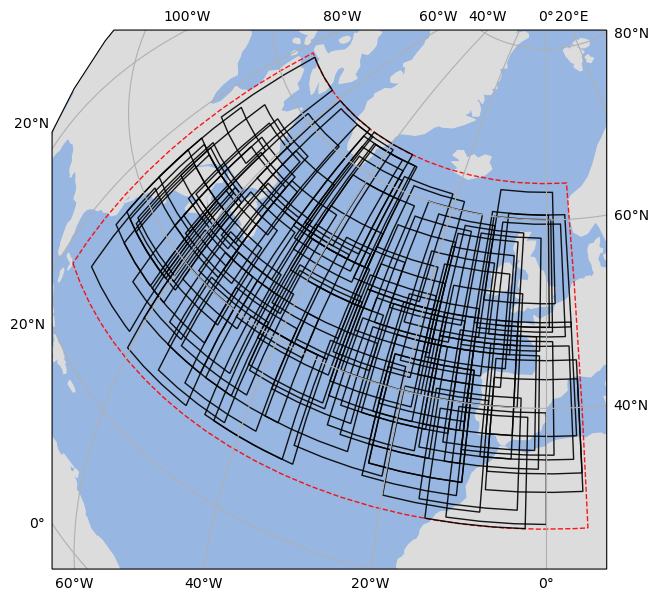

In [3]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from random import sample 

map_proj = ccrs.Orthographic(0, 45)
map_proj._threshold /= 100.

fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, color='gainsboro',zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
lon_min = -77
lon_max = 5
lat_min = 27
lat_max = 64
extent = [np.min(data.lon)-2,np.max(data.lon)+2,np.min(data.lat)-2,np.max(data.lat)+2]
ax.set_extent(extent, crs=ccrs.PlateCarree())

coords = datamodule.train_ds.get_coords()

# Baltic
ax.add_patch(mpatches.Rectangle(xy=[lon_min, lat_min], width=82, height=37,
                                    edgecolor='red',
                                    linestyle="dashed",
                                    alpha=0.9,
                                    facecolor="none",
                                    transform=ccrs.PlateCarree()))

for i in range(0,100):
    # test1
    ax.add_patch(mpatches.Rectangle(xy=[coords[i].lon[0], coords[i].lat[0]], 
                                    width=datamodule.xrds_kw['patch_dims']['lon']*0.1,
                                    height=datamodule.xrds_kw['patch_dims']['lat']*0.1,
                                    edgecolor='black',
                                    facecolor="none",
                                    alpha=0.9,
                                    transform=ccrs.PlateCarree()))      
plt.savefig("/DATASET/mbeauchamp/IMT/4DVarNet_outputs/SPDE/patching_train_new.png",bbox_inches='tight')

## 1.2 Plot the testing batches

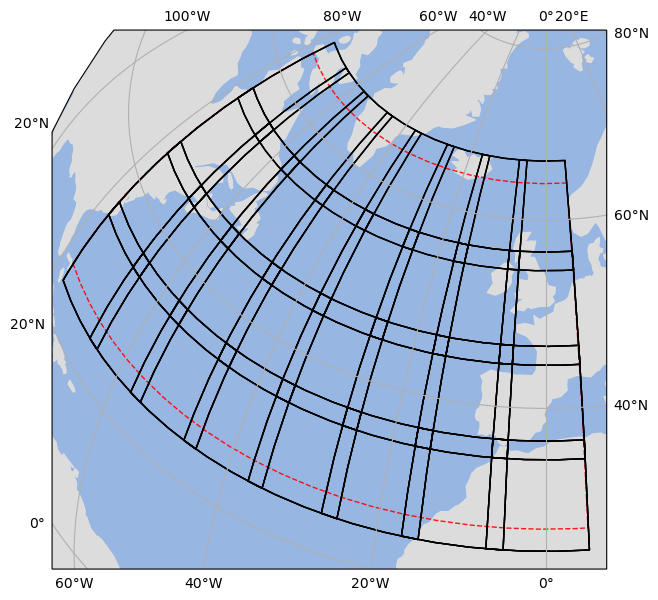

In [47]:
fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, color='gainsboro',zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
lon_min = -77
lon_max = 5
lat_min = 27
lat_max = 64
extent = [np.min(data.lon)-2,np.max(data.lon)+2,np.min(data.lat)-2,np.max(data.lat)+2]
ax.set_extent(extent, crs=ccrs.PlateCarree())


coords = datamodule_for_test.test_ds.get_coords()

# Baltic
ax.add_patch(mpatches.Rectangle(xy=[lon_min, lat_min], width=82, height=37,
                                    edgecolor='red',
                                    linestyle="dashed",
                                    alpha=0.9,
                                    facecolor="none",
                                    transform=ccrs.PlateCarree()))

for i in range(120):
    ax.add_patch(mpatches.Rectangle(xy=[coords[i].lon[0], coords[i].lat[0]],
                                    width=datamodule.xrds_kw['patch_dims']['lon']*0.1,
                                    height=datamodule.xrds_kw['patch_dims']['lat']*0.1,
                                    edgecolor='black',
                                    facecolor="none",
                                    alpha=0.9,
                                    transform=ccrs.PlateCarree()))        
plt.savefig("/DATASET/mbeauchamp/IMT/4DVarNet_outputs/SPDE/patching_test_new.png",bbox_inches='tight')

## 1.3 Mapping

In [4]:
from matplotlib import colors as cl

def plot(ax, lon, lat, data, title, cmap, norm, extent=[-65, -55, 30, 40], colorbar=True, orientation="horizontal", extend="neither"):
    ax.set_extent(list(extent))
    im=ax.pcolormesh(lon, lat, data, cmap=cmap, shading='nearest', \
                          norm=norm, edgecolors='face', alpha=1, \
                          transform=ccrs.PlateCarree(central_longitude=0.0))
    if colorbar==True:
        clb = plt.colorbar(im, orientation=orientation, extend=extend, pad=0.1, ax=ax)
        clb.ax.set_title(title,fontsize=20,y=-2.25)
        clb.ax.tick_params(labelsize=16)
    else:
        ax.set_title(title,fontsize = 18)
    #ax.add_feature(cfeature.LAND.with_scale('10m'), zorder=100,
    #               edgecolor='k')#, facecolor='white')
    gl = ax.gridlines(alpha=0.5, zorder=200)#,draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 10, 'rotation' : 45}
    gl.ylabel_style = {'fontsize': 10}
    
def inset_plot(ax, bbox, loc, map_proj, col="red", label="", pos="top"):
    ax.add_patch(mpatches.Rectangle(xy=[bbox[0],bbox[2]], width=bbox[1]-bbox[0], height=bbox[3]-bbox[2],
                                    edgecolor=col,
                                    linestyle="dashed",
                                    alpha=0.9,
                                    facecolor="none",
                                    transform=ccrs.PlateCarree()))
    x1, x2, y1, y2 = bbox
    if pos=="top":
        ax.text(x1+1, y2+1, label, fontsize=12, color="white", transform=ccrs.PlateCarree())
    else:
        ax.text(x1+1, y1-1, label, fontsize=12, color="white", transform=ccrs.PlateCarree())

    # inset plots
    x1, x2, y1, y2 = 7.1, 13.9, 43.8, 47.1  # subregion of the original image
    axins = ax.inset_axes(
             loc,
             xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[],
             projection=ccrs.PlateCarree())
    axins.add_feature(cartopy.feature.OCEAN, zorder=0)
    axins.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
    gl = axins.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    #ax.indicate_inset_zoom(axins, edgecolor="black", alpha=1)        
    return axins

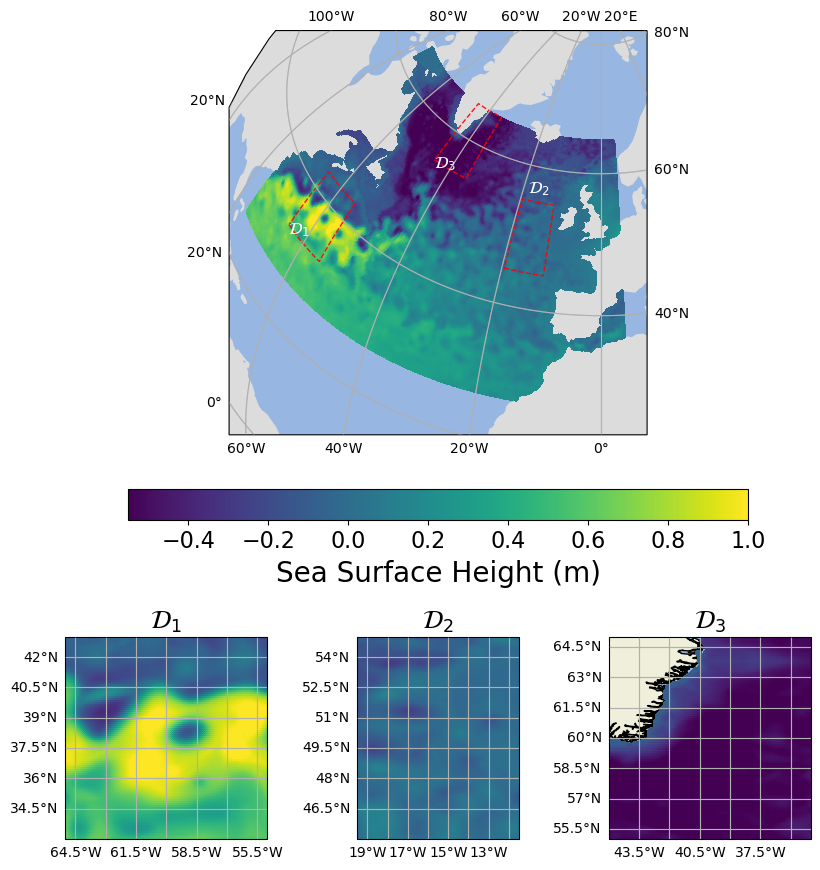

In [5]:
fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, color='gainsboro',zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
lon_min = -77
lon_max = 5
lat_min = 27
lat_max = 64
extent = [np.min(data.lon)-2,np.max(data.lon)+2,np.min(data.lat)-2,np.max(data.lat)+2]
ax.set_extent(extent, crs=ccrs.PlateCarree())

vmax = -.5
vmin = 1
cm = plt.cm.viridis
norm = cl.Normalize(vmin=vmin, vmax=vmax)
plot(ax, data.lon, data.lat, data.tgt.isel(time=9).where(data.mask==1.), 'Sea Surface Height (m)', extent=extent, cmap=cm, norm=norm, colorbar=True)

#inset plots
lon = data.lon
lat = data.lat
axins = inset_plot(ax,bbox=[-65, -55, 33, 43],loc=[-.4, -1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_1$",pos="bottom")
plot(axins,lon,lat,data.tgt.isel(time=9).where(data.mask==1.),'$\mathcal{D}_1$',extent=[-65, -55, 33, 43],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-19.5, -11.5, 45, 55],loc=[.25, -1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_2$")
plot(axins,lon,lat,data.tgt.isel(time=9).where(data.mask==1.),'$\mathcal{D}_2$',extent=[-19.5, -11.5, 45, 55],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-45, -35, 55, 65],loc=[.9, -1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_3$", pos="bottom")
plot(axins,lon,lat,data.tgt.isel(time=9).where(data.mask==1.),'$\mathcal{D}_3$',extent=[-45, -35, 55, 65],cmap=cm,norm=norm,colorbar=False)
plt.savefig("/DATASET/mbeauchamp/IMT/4DVarNet_outputs/SPDE/NATL_gt.png",bbox_inches='tight')

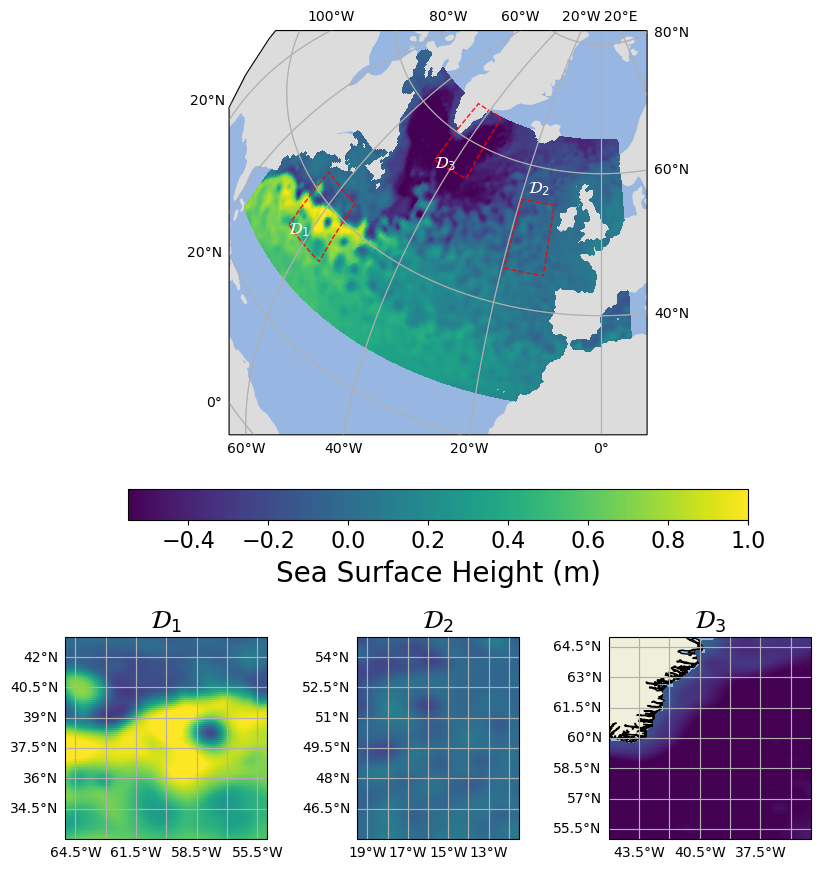

In [37]:
fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, color='gainsboro',zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
lon_min = -77
lon_max = 5
lat_min = 27
lat_max = 64
extent = [np.min(data.lon)-2,np.max(data.lon)+2,np.min(data.lat)-2,np.max(data.lat)+2]
ax.set_extent(extent, crs=ccrs.PlateCarree())

map_proj = ccrs.Orthographic(0, 45)
map_proj._threshold /= 100.
vmax = -.5
vmin = 1
cm = plt.cm.viridis
norm = cl.Normalize(vmin=vmin, vmax=vmax)
data = data.update({"oi":(("lat","lon"),np.where(data.oi>10,np.nan,data.oi))})
plot(ax, data.lon, data.lat, data.oi,  'Sea Surface Height (m)', extent=extent, cmap=cm, norm=norm, colorbar=True)

#inset plots
lon = data.lon
lat = data.lat
axins = inset_plot(ax,bbox=[-65, -55, 33, 43],loc=[-.4, -1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_1$",pos="bottom")
plot(axins,lon,lat,data.oi.where(data.mask==1.),'$\mathcal{D}_1$',extent=[-65, -55, 33, 43],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-19.5, -11.5, 45, 55],loc=[.25, -1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_2$")
plot(axins,lon,lat,data.oi.where(data.mask==1.),'$\mathcal{D}_2$',extent=[-19.5, -11.5, 45, 55],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-45, -35, 55, 65],loc=[.9, -1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_3$", pos="bottom")
plot(axins,lon,lat,data.oi.where(data.mask==1.),'$\mathcal{D}_3$',extent=[-45, -35, 55, 65],cmap=cm,norm=norm,colorbar=False)
plt.savefig("/DATASET/mbeauchamp/IMT/4DVarNet_outputs/SPDE/NATL_oi.png",bbox_inches='tight')

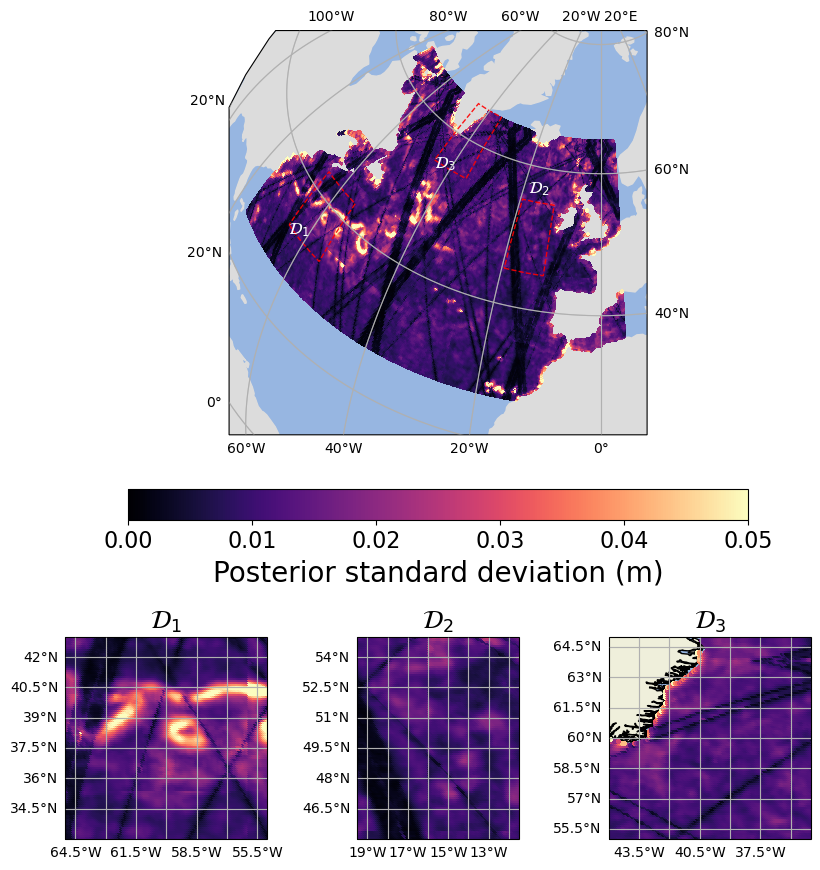

In [38]:
fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, color='gainsboro',zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
lon_min = -77
lon_max = 5
lat_min = 27
lat_max = 64
extent = [np.min(data.lon)-2,np.max(data.lon)+2,np.min(data.lat)-2,np.max(data.lat)+2]
ax.set_extent(extent, crs=ccrs.PlateCarree())

vmax = .05
vmin = 0
cm = plt.cm.magma
norm = cl.Normalize(vmin=vmin, vmax=vmax)
plot(ax, data.lon, data.lat, data.std_simu.isel(time=7,daw=2).where(data.mask==1.),  'Posterior standard deviation (m)', extent=extent, cmap=cm, norm=norm, colorbar=True)
#inset plots
lon = data.lon
lat = data.lat
axins = inset_plot(ax,bbox=[-65, -55, 33, 43],loc=[-.4, -1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_1$",pos="bottom")
plot(axins,lon,lat,data.std_simu.isel(time=7,daw=2).where(data.mask==1.),'$\mathcal{D}_1$',extent=[-65, -55, 33, 43],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-19.5, -11.5, 45, 55],loc=[.25, -1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_2$")
plot(axins,lon,lat,data.std_simu.isel(time=7,daw=2).where(data.mask==1.),'$\mathcal{D}_2$',extent=[-19.5, -11.5, 45, 55],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-45, -35, 55, 65],loc=[.9, -1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_3$", pos="bottom")
plot(axins,lon,lat,data.std_simu.isel(time=7,daw=2).where(data.mask==1.),'$\mathcal{D}_3$',extent=[-45, -35, 55, 65],cmap=cm,norm=norm,colorbar=False)
plt.savefig("/DATASET/mbeauchamp/IMT/4DVarNet_outputs/SPDE/NATL_std.png",bbox_inches='tight')

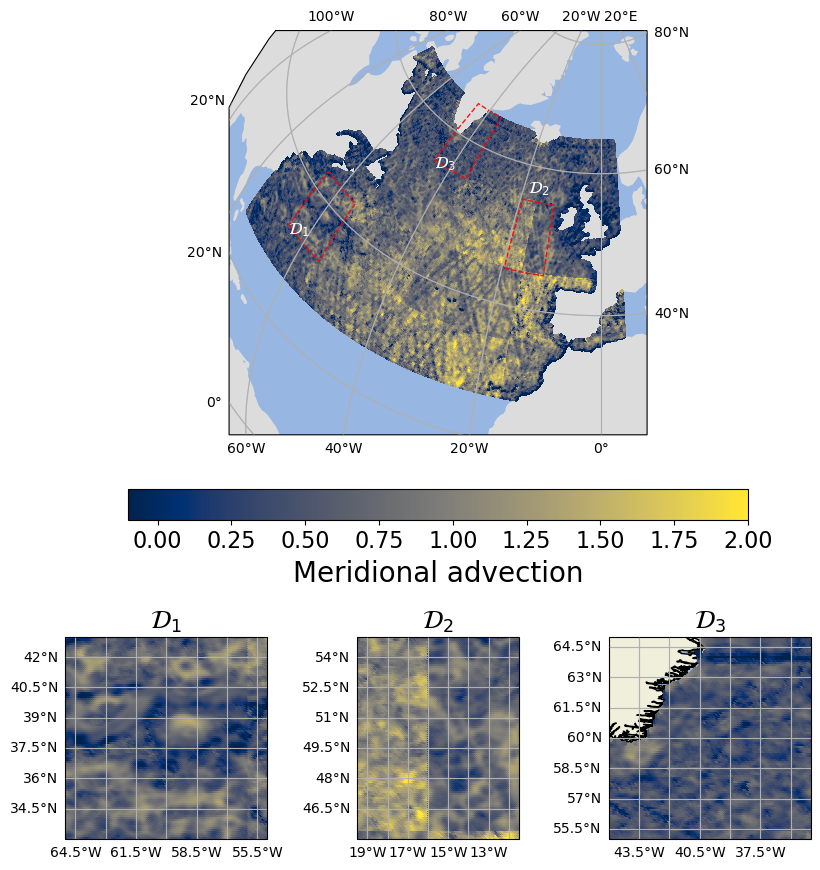

In [17]:
fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, color='gainsboro',zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
lon_min = -77
lon_max = 5
lat_min = 27
lat_max = 64
extent = [np.min(data.lon)-2,np.max(data.lon)+2,np.min(data.lat)-2,np.max(data.lat)+2]
ax.set_extent(extent, crs=ccrs.PlateCarree())

vmax = 0
vmin = 2
cm = plt.cm.cividis
norm = cl.Normalize(vmin=vmin, vmax=vmax)
plot(ax, data.lon, data.lat, data.m2.isel(time=7,daw=2).where(data.mask==1.), 'Meridional advection', extent=extent, cmap=cm, norm=norm, colorbar=True)

#inset plots
lon = data.lon
lat = data.lat
axins = inset_plot(ax,bbox=[-65, -55, 33, 43],loc=[-.4, -1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_1$",pos="bottom")
plot(axins,lon,lat,data.m2.isel(time=7,daw=2).where(data.mask==1.),'$\mathcal{D}_1$',extent=[-65, -55, 33, 43],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-19.5, -11.5, 45, 55],loc=[.25, -1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_2$")
plot(axins,lon,lat,data.m2.isel(time=7,daw=2).where(data.mask==1.),'$\mathcal{D}_2$',extent=[-19.5, -11.5, 45, 55],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-45, -35, 55, 65],loc=[.9, -1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_3$", pos="bottom")
plot(axins,lon,lat,data.m2.isel(time=7,daw=2).where(data.mask==1.),'$\mathcal{D}_3$',extent=[-45, -35, 55, 65],cmap=cm,norm=norm,colorbar=False)
plt.savefig("/DATASET/mbeauchamp/IMT/4DVarNet_outputs/SPDE/NATL_m2.png",bbox_inches='tight')

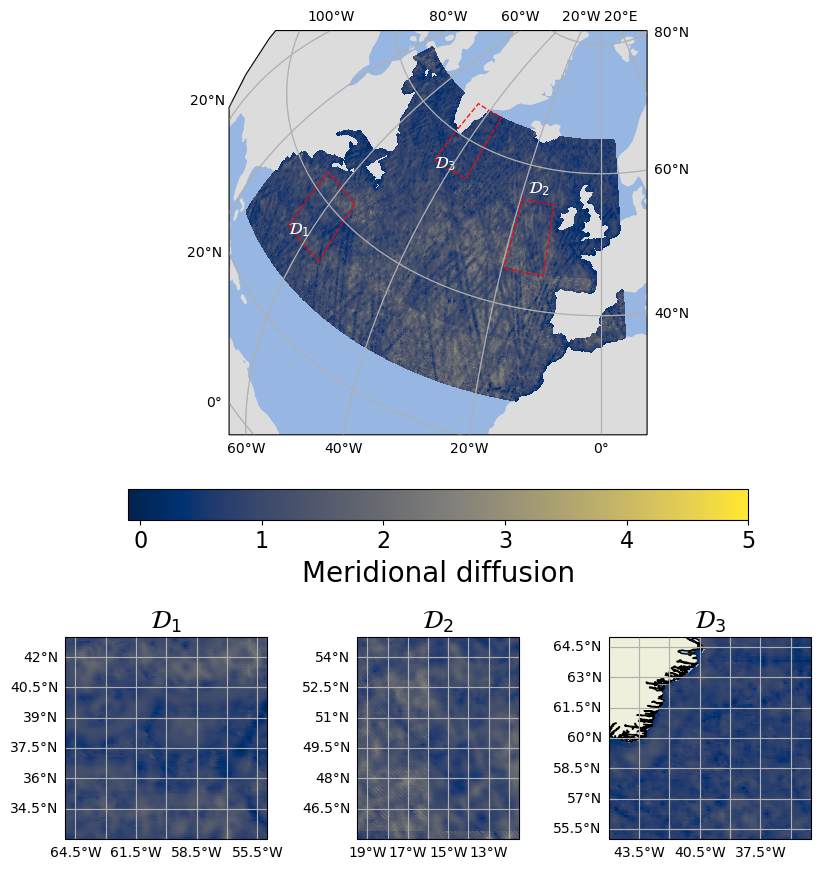

In [21]:
fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, color='gainsboro',zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
lon_min = -77
lon_max = 5
lat_min = 27
lat_max = 64
extent = [np.min(data.lon)-2,np.max(data.lon)+2,np.min(data.lat)-2,np.max(data.lat)+2]
ax.set_extent(extent, crs=ccrs.PlateCarree())

vmax = 0
vmin = 5
cm = plt.cm.cividis
norm = cl.Normalize(vmin=vmin, vmax=vmax)
plot(ax, data.lon, data.lat, data.H22.isel(time=7,daw=2).where(data.mask==1.), 'Meridional diffusion', extent=extent, cmap=cm, norm=norm, colorbar=True)

#inset plots
lon = data.lon
lat = data.lat
axins = inset_plot(ax,bbox=[-65, -55, 33, 43],loc=[-.4, -1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_1$",pos="bottom")
plot(axins,lon,lat,data.H22.isel(time=7,daw=2).where(data.mask==1.),'$\mathcal{D}_1$',extent=[-65, -55, 33, 43],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-19.5, -11.5, 45, 55],loc=[.25, -1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_2$")
plot(axins,lon,lat,data.H22.isel(time=7,daw=2).where(data.mask==1.),'$\mathcal{D}_2$',extent=[-19.5, -11.5, 45, 55],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-45, -35, 55, 65],loc=[.9, -1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_3$", pos="bottom")
plot(axins,lon,lat,data.H22.isel(time=7,daw=2).where(data.mask==1.),'$\mathcal{D}_3$',extent=[-45, -35, 55, 65],cmap=cm,norm=norm,colorbar=False)
plt.savefig("/DATASET/mbeauchamp/IMT/4DVarNet_outputs/SPDE/NATL_H22.png",bbox_inches='tight')

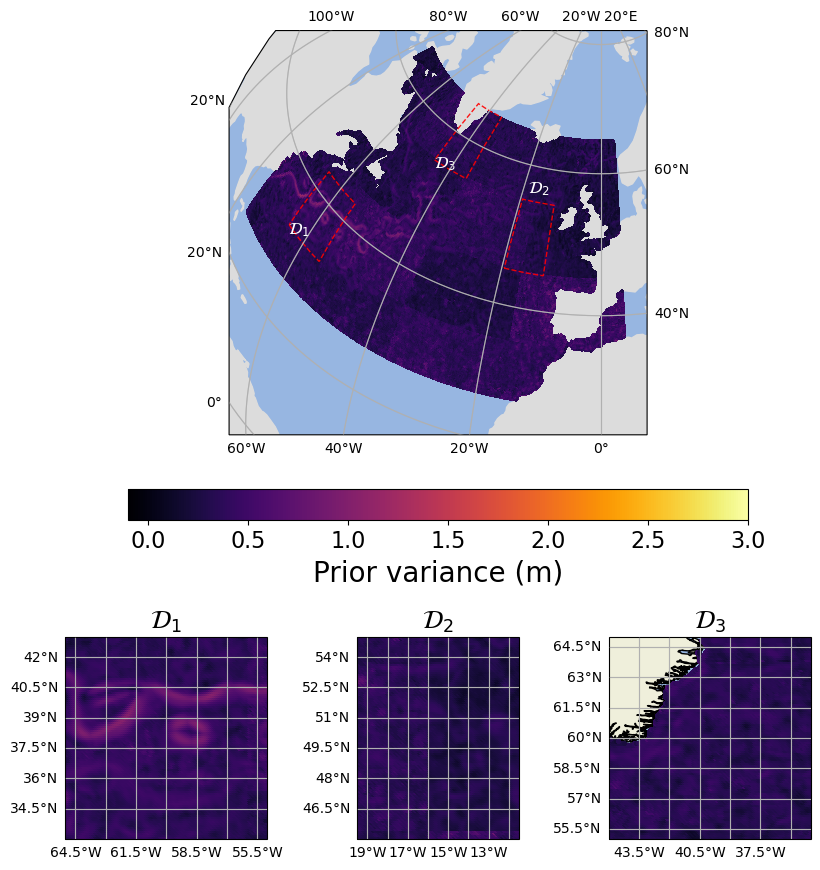

In [42]:
fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, color='gainsboro',zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
lon_min = -77
lon_max = 5
lat_min = 27
lat_max = 64
extent = [np.min(data.lon)-2,np.max(data.lon)+2,np.min(data.lat)-2,np.max(data.lat)+2]
ax.set_extent(extent, crs=ccrs.PlateCarree())

vmax = 0
vmin = 3
cm = plt.cm.inferno
norm = cl.Normalize(vmin=vmin, vmax=vmax)
plot(ax, data.lon, data.lat, data.tau.isel(time=7,daw=2).where(data.mask==1.), 'Prior variance (m)', extent=extent, cmap=cm, norm=norm, colorbar=True)

#inset plots
lon = data.lon
lat = data.lat
axins = inset_plot(ax,bbox=[-65, -55, 33, 43],loc=[-.4, -1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_1$",pos="bottom")
plot(axins,lon,lat,data.tau.isel(time=7,daw=2).where(data.mask==1.),'$\mathcal{D}_1$',extent=[-65, -55, 33, 43],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-19.5, -11.5, 45, 55],loc=[.25, -1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_2$")
plot(axins,lon,lat,data.tau.isel(time=7,daw=2).where(data.mask==1.),'$\mathcal{D}_2$',extent=[-19.5, -11.5, 45, 55],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-45, -35, 55, 65],loc=[.9, -1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_3$", pos="bottom")
plot(axins,lon,lat,data.tau.isel(time=7,daw=2).where(data.mask==1.),'$\mathcal{D}_3$',extent=[-45, -35, 55, 65],cmap=cm,norm=norm,colorbar=False)
plt.savefig("/DATASET/mbeauchamp/IMT/4DVarNet_outputs/SPDE/NATL_tau.png",bbox_inches='tight')

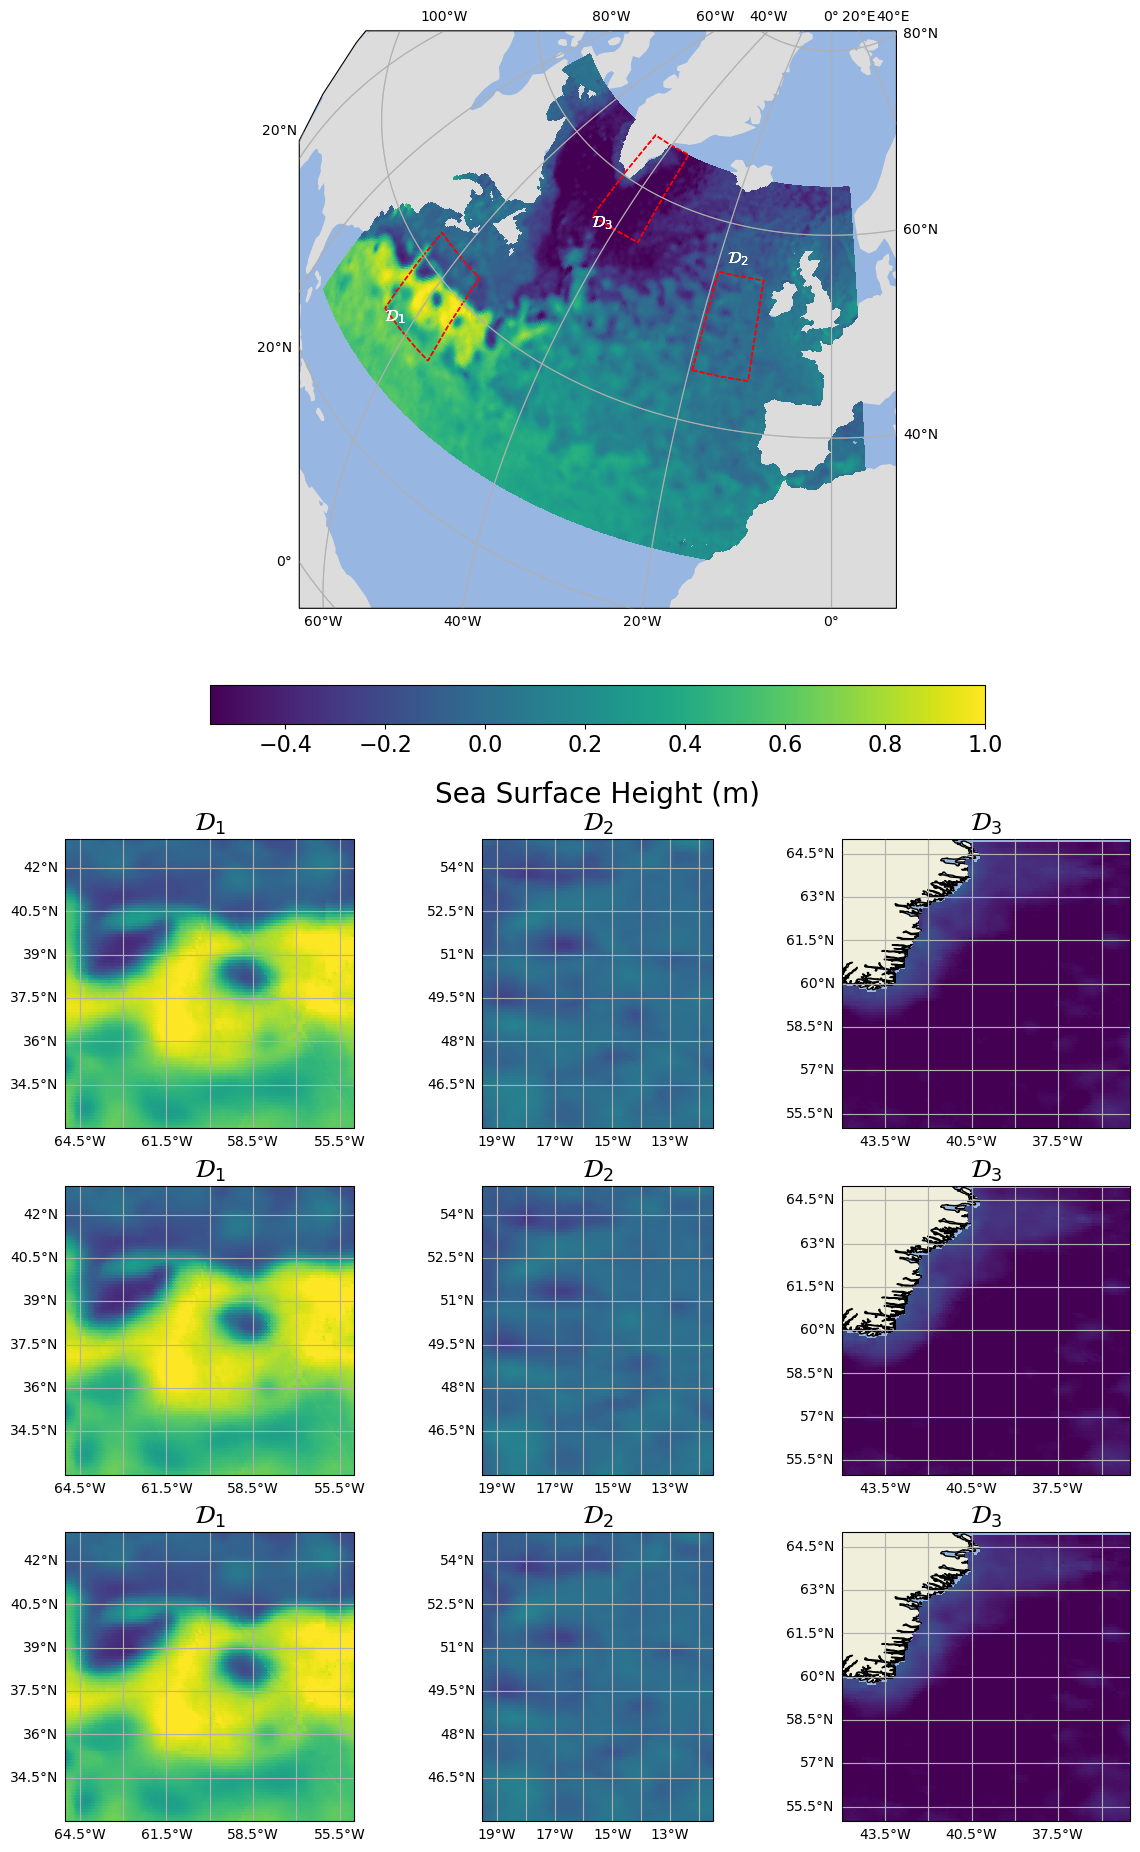

In [43]:
fig, ax = plt.subplots(figsize=(10,10),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, color='gainsboro',zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
lon_min = -77
lon_max = 5
lat_min = 27
lat_max = 64
extent = [np.min(data.lon)-2,np.max(data.lon)+2,np.min(data.lat)-2,np.max(data.lat)+2]
ax.set_extent(extent, crs=ccrs.PlateCarree())

map_proj = ccrs.Orthographic(0, 45)
map_proj._threshold /= 100.
vmax = -.5
vmin = 1
cm = plt.cm.viridis
norm = cl.Normalize(vmin=vmin, vmax=vmax)
plot(ax, data.lon, data.lat, data.sample_xy.isel(time=7,daw=2,simu=10).where(data.mask==1.), 'Sea Surface Height (m)', extent=extent, cmap=cm, norm=norm, colorbar=True)

#inset plots
lon = data.lon
lat = data.lat
axins = inset_plot(ax,bbox=[-65, -55, 33, 43],loc=[-.4, -.9, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_1$",pos="bottom")
plot(axins,lon,lat,data.sample_xy.isel(time=7,daw=2,simu=10).where(data.mask==1.),'$\mathcal{D}_1$',extent=[-65, -55, 33, 43],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-19.5, -11.5, 45, 55],loc=[.25, -.9, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_2$")
plot(axins,lon,lat,data.sample_xy.isel(time=7,daw=2,simu=10).where(data.mask==1.),'$\mathcal{D}_2$',extent=[-19.5, -11.5, 45, 55],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-45, -35, 55, 65],loc=[.9, -.9, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_3$", pos="bottom")
plot(axins,lon,lat,data.sample_xy.isel(time=7,daw=2,simu=10).where(data.mask==1.),'$\mathcal{D}_3$',extent=[-45, -35, 55, 65],cmap=cm,norm=norm,colorbar=False)

axins = inset_plot(ax,bbox=[-65, -55, 33, 43],loc=[-.4, -1.5, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_1$",pos="bottom")
plot(axins,lon,lat,data.sample_xy.isel(time=7,daw=2,simu=20).where(data.mask==1.),'$\mathcal{D}_1$',extent=[-65, -55, 33, 43],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-19.5, -11.5, 45, 55],loc=[.25, -1.5, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_2$")
plot(axins,lon,lat,data.sample_xy.isel(time=7,daw=2,simu=20).where(data.mask==1.),'$\mathcal{D}_2$',extent=[-19.5, -11.5, 45, 55],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-45, -35, 55, 65],loc=[.9, -1.5, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_3$", pos="bottom")
plot(axins,lon,lat,data.sample_xy.isel(time=7,daw=2,simu=20).where(data.mask==1.),'$\mathcal{D}_3$',extent=[-45, -35, 55, 65],cmap=cm,norm=norm,colorbar=False)

axins = inset_plot(ax,bbox=[-65, -55, 33, 43],loc=[-.4, -2.1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_1$",pos="bottom")
plot(axins,lon,lat,data.sample_xy.isel(time=7,daw=2,simu=30).where(data.mask==1.),'$\mathcal{D}_1$',extent=[-65, -55, 33, 43],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-19.5, -11.5, 45, 55],loc=[.25, -2.1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_2$")
plot(axins,lon,lat,data.sample_xy.isel(time=7,daw=2,simu=30).where(data.mask==1.),'$\mathcal{D}_2$',extent=[-19.5, -11.5, 45, 55],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-45, -35, 55, 65],loc=[.9, -2.1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_3$", pos="bottom")
plot(axins,lon,lat,data.sample_xy.isel(time=7,daw=2,simu=30).where(data.mask==1.),'$\mathcal{D}_3$',extent=[-45, -35, 55, 65],cmap=cm,norm=norm,colorbar=False)
plt.savefig("/DATASET/mbeauchamp/IMT/4DVarNet_outputs/SPDE/NATL_simu.png",bbox_inches='tight')

In [16]:
import metpy.calc as mpcalc
def add_geo_attrs(da):
    da["lon"] = da.lon.assign_attrs(units="degrees_east")
    da["lat"] = da.lat.assign_attrs(units="degrees_north")
    return da

def vort(da):
    return mpcalc.vorticity(
            *mpcalc.geostrophic_wind(
                da.pipe(add_geo_attrs).assign_attrs(units="m").metpy.quantify()
            )
        ).metpy.dequantify()

def compute_grad(da):
    return np.sqrt(da.differentiate("lon")**2 + da.differentiate("lat")**2)

#data_vort = vort(data.isel(simu=[10,20,30]))
data_grad = compute_grad(data.isel(simu=[10,20,30]))

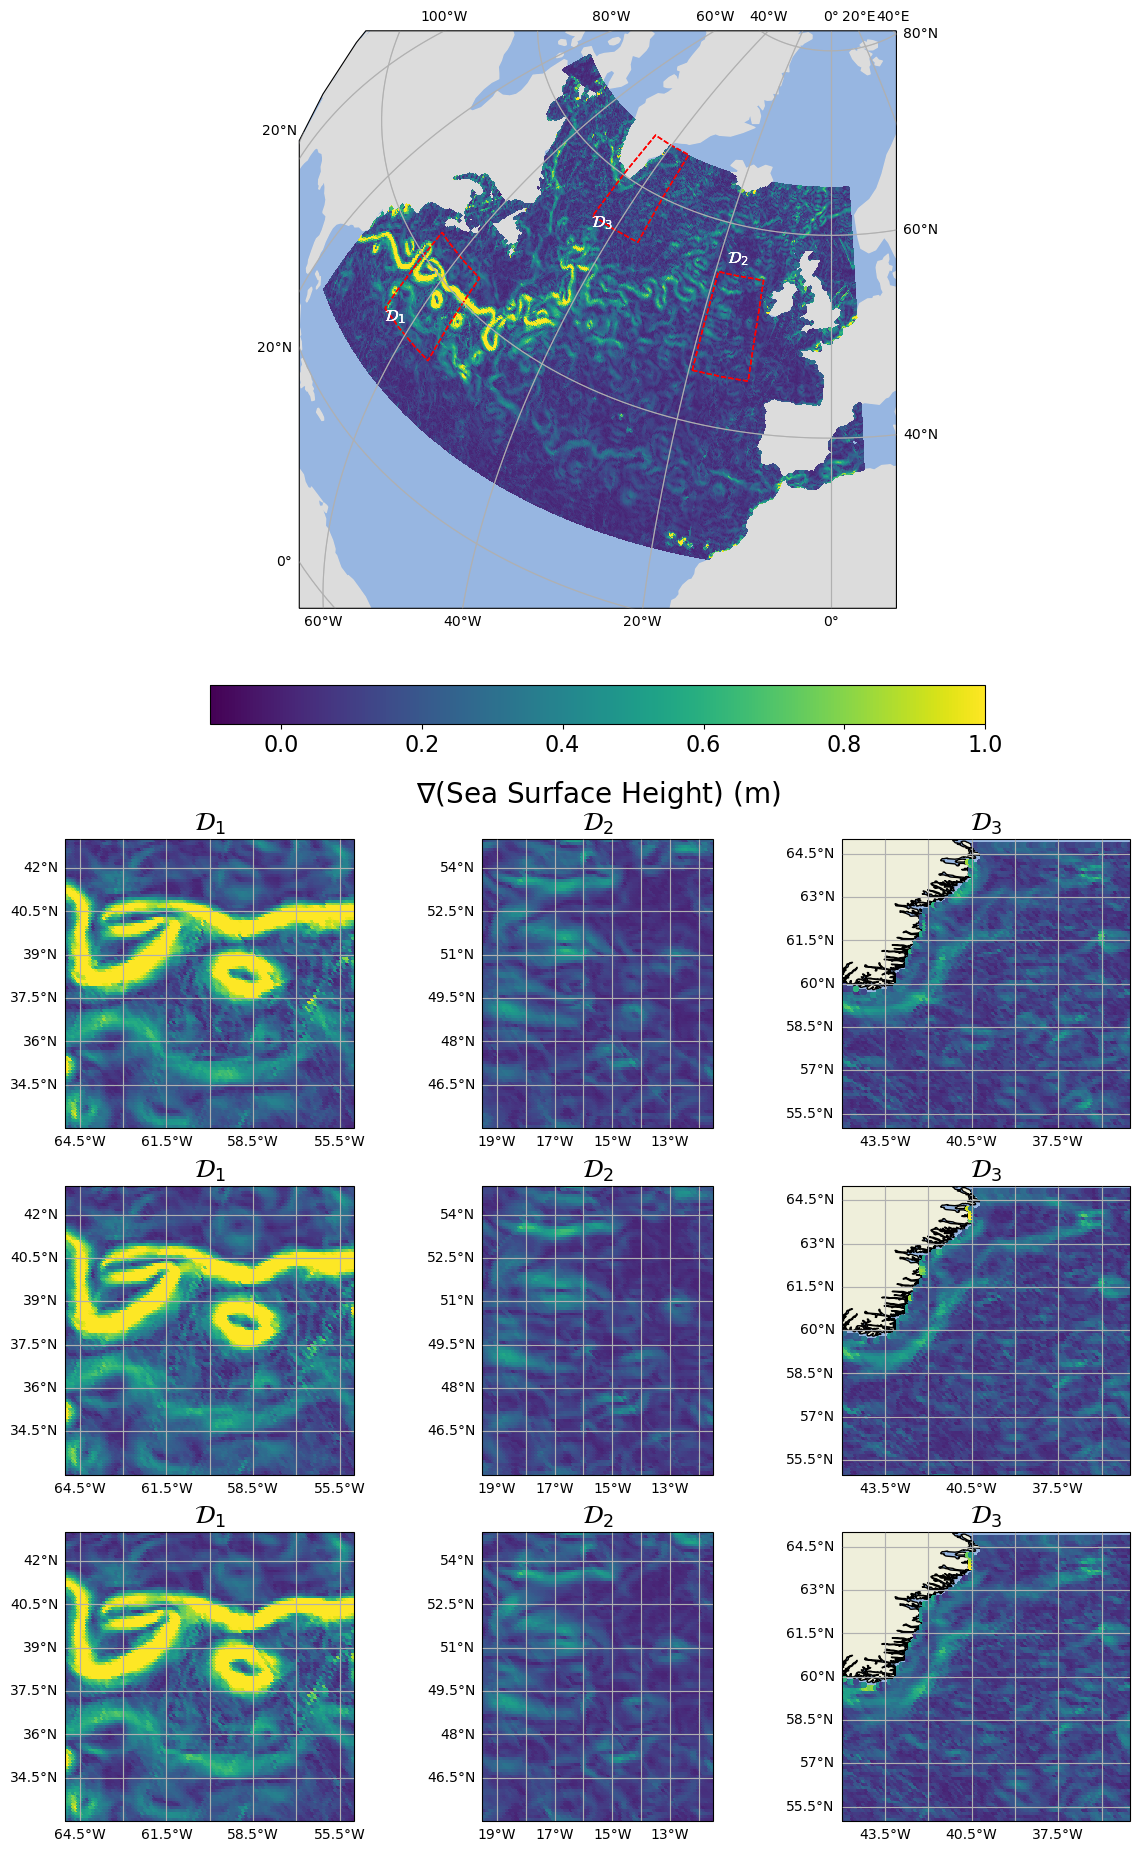

In [44]:
fig, ax = plt.subplots(figsize=(10,10),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, color='gainsboro',zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
lon_min = -77
lon_max = 5
lat_min = 27
lat_max = 64
extent = [np.min(data_grad.lon)-2,np.max(data_grad.lon)+2,np.min(data_grad.lat)-2,np.max(data_grad.lat)+2]
ax.set_extent(extent, crs=ccrs.PlateCarree())

map_proj = ccrs.Orthographic(0, 45)
map_proj._threshold /= 100.
vmax = 0
vmin = 1
cm = plt.cm.viridis
norm = cl.Normalize(vmin=vmin, vmax=vmax)
plot(ax, data_grad.lon, data_grad.lat, data_grad.sample_xy.isel(time=7,daw=2,simu=1).where(data_grad.mask==1.), r'$\nabla$(Sea Surface Height) (m)', extent=extent, cmap=cm, norm=norm, colorbar=True)

#inset plots
lon = data_grad.lon
lat = data_grad.lat
axins = inset_plot(ax,bbox=[-65, -55, 33, 43],loc=[-.4, -.9, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_1$",pos="bottom")
plot(axins,lon,lat,data_grad.sample_xy.isel(time=7,daw=2,simu=0).where(data_grad.mask==1.),'$\mathcal{D}_1$',extent=[-65, -55, 33, 43],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-19.5, -11.5, 45, 55],loc=[.25, -.9, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_2$")
plot(axins,lon,lat,data_grad.sample_xy.isel(time=7,daw=2,simu=0).where(data_grad.mask==1.),'$\mathcal{D}_2$',extent=[-19.5, -11.5, 45, 55],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-45, -35, 55, 65],loc=[.9, -.9, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_3$", pos="bottom")
plot(axins,lon,lat,data_grad.sample_xy.isel(time=7,daw=2,simu=0).where(data_grad.mask==1.),'$\mathcal{D}_3$',extent=[-45, -35, 55, 65],cmap=cm,norm=norm,colorbar=False)

axins = inset_plot(ax,bbox=[-65, -55, 33, 43],loc=[-.4, -1.5, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_1$",pos="bottom")
plot(axins,lon,lat,data_grad.sample_xy.isel(time=7,daw=2,simu=1).where(data_grad.mask==1.),'$\mathcal{D}_1$',extent=[-65, -55, 33, 43],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-19.5, -11.5, 45, 55],loc=[.25, -1.5, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_2$")
plot(axins,lon,lat,data_grad.sample_xy.isel(time=7,daw=2,simu=1).where(data_grad.mask==1.),'$\mathcal{D}_2$',extent=[-19.5, -11.5, 45, 55],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-45, -35, 55, 65],loc=[.9, -1.5, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_3$", pos="bottom")
plot(axins,lon,lat,data_grad.sample_xy.isel(time=7,daw=2,simu=1).where(data_grad.mask==1.),'$\mathcal{D}_3$',extent=[-45, -35, 55, 65],cmap=cm,norm=norm,colorbar=False)

axins = inset_plot(ax,bbox=[-65, -55, 33, 43],loc=[-.4, -2.1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_1$",pos="bottom")
plot(axins,lon,lat,data_grad.sample_xy.isel(time=7,daw=2,simu=2).where(data_grad.mask==1.),'$\mathcal{D}_1$',extent=[-65, -55, 33, 43],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-19.5, -11.5, 45, 55],loc=[.25, -2.1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_2$")
plot(axins,lon,lat,data_grad.sample_xy.isel(time=7,daw=2,simu=2).where(data_grad.mask==1.),'$\mathcal{D}_2$',extent=[-19.5, -11.5, 45, 55],cmap=cm,norm=norm,colorbar=False)
axins = inset_plot(ax,bbox=[-45, -35, 55, 65],loc=[.9, -2.1, .5, .5], map_proj=map_proj, label=r"$\mathcal{D}_3$", pos="bottom")
plot(axins,lon,lat,data_grad.sample_xy.isel(time=7,daw=2,simu=2).where(data_grad.mask==1.),'$\mathcal{D}_3$',extent=[-45, -35, 55, 65],cmap=cm,norm=norm,colorbar=False)
plt.savefig("/DATASET/mbeauchamp/IMT/4DVarNet_outputs/SPDE/NATL_simu_grad.png",bbox_inches='tight')

In [34]:
import sys
import xarray as xr
from src.utils import rmse_based_scores_from_ds
from src.utils import psd_based_scores_from_ds

def compute_metrics(bbox=None, var="out"):
    if bbox is not None:
        new_data = data.sel(lon=slice(bbox[0],bbox[1]),lat=slice(bbox[2],bbox[3]))
    else:
        new_data = data 
    mu, sig = rmse_based_scores_from_ds(new_data.sel(time=slice('2012-10-22', '2012-12-02',)), ref_variable='tgt', study_variable=var)
    lx , lt = psd_based_scores_from_ds(new_data.sel(time=slice('2012-10-22', '2012-12-02',)), ref_variable='tgt', study_variable=var)
    print(mu,sig,lx,lt)
    
compute_metrics()
compute_metrics(bbox=[-65, -55, 33, 43])
compute_metrics(bbox=[-19.5, -11.5, 45, 55])
compute_metrics(bbox=[-45, -35, 55, 65])

compute_metrics(var="oi")
compute_metrics(bbox=[-65, -55, 33, 43],var="oi")
compute_metrics(bbox=[-19.5, -11.5, 45, 55],var="oi")
compute_metrics(bbox=[-45, -35, 55, 65],var="oi")

0.86772 0.00232 nan nan
0.90357 0.00436 nan nan
0.7394 0.00723 nan nan
0.93206 0.00448 nan nan
0.71082 0.00325 nan nan
0.61355 0.00191 nan nan
0.24821 0.00062 nan nan
0.90403 0.00523 nan nan
